# Messing around with spatial clustering in Mesa/python

We need our trees to have some sort of clustering coefficient, because some of my questions focus on deforestation and fragmentation. Let's try a Thomas process for generating clustering. This is adapted from Connor Johnson's [blog post](http://connor-johnson.com/2014/02/25/spatial-point-processes/) on point processes in python.

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We need a basic 2-D poisson-process for creating events. Rt is our variable for the average number of events for a given square size, which is defined by the side length variable Dx. Also built-in here is a y-dimension, so this function can handle rectangles. But I don't think we'll use this option much. 

In [4]:
def PoissonPP( rt, Dx, Dy=None ):
    '''
    Determines the number of events `N` for a rectangular region,
    given the rate `rt` and the dimensions, `Dx`, `Dy`.
    Returns a <2xN> NumPy array.
    '''
    if Dy == None:
        Dy = Dx
    N = scipy.stats.poisson( rt*Dx*Dy ).rvs()
    x = scipy.stats.uniform.rvs(0,Dx,((N,1)))
    y = scipy.stats.uniform.rvs(0,Dy,((N,1)))
    P = np.hstack((x,y))
    return(P)

Try it out, visualize:

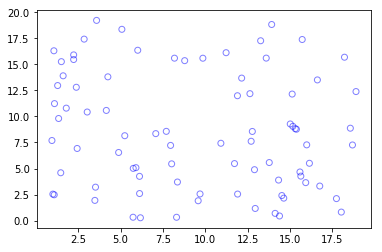

In [26]:
rate, Dx = 0.2, 20
P = PoissonPP( rate, Dx ).T
plt.scatter( P[0], P[1], edgecolor='b', facecolor='none', alpha=0.5 )
#plt.show()

Now we can use this to seed a cluster-generation process. The above poisson process will seed a landscape with "parent" points. The function below then places "child" points around these parent points. Here we'll use a Thomas process, which generates points around the parent in with a gaussian-type distribution, radially. A common alternative would be to use a matern process, but the Thomas process seems a little more intuitive to me. 

In [5]:
def ThomasPP( kappa, sigma, mu, Dx ):
    '''
    each forming a Poisson( mu ) numbered cluster of points,
    having an isotropic Gaussian distribution with variance `sigma`
    '''
    # create a set of parent points from a Poisson( kappa )
    # distribution on the square region [0,Dx] X [0,Dx]
    parents = PoissonPP( kappa, Dx )
    # M is the number of parents
    M = parents.shape[0]
    # an empty list for the Thomas process points
    TP = list()
    # for each parent point..
    for i in range( M ):
        # determine a number of children according
        # to a Poisson( mu ) distribution
        N = scipy.stats.poisson( mu ).rvs()
    # for each child point..
        for j in range( N ):
        # place a point centered on the location of the parent according
        # to an isotropic Gaussian distribution with sigma variance
                pdf = scipy.stats.norm( loc=parents[i,:2], scale=(sigma,sigma) )
                # add the child point to the list TP
                TP.append( list( pdf.rvs(2) ) )
    x,y = zip(*TP)
    pts = [x,y]
    return pts


Kappa determines the density of parent points on the landscape, +/- equivalent to the number of clusters. Mu determines the poisson rate of the secondary clusters, +/- controls number of child points. Sigma is the variance on the the spread of the child points, so this should act to concentrate (tighten up) the clusters, more events in a smaller radius. 

In [ ]:
So what happens when we vary the parameters?

In [28]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=15, Dx=8)

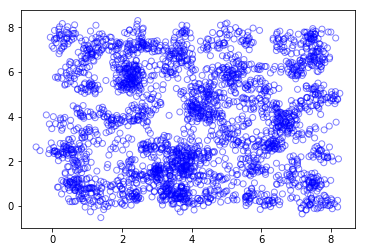

In [31]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

Compare this to a lowered 

In [32]:
aa = ThomasPP(kappa=3, sigma=0.1, mu=15, Dx=8)

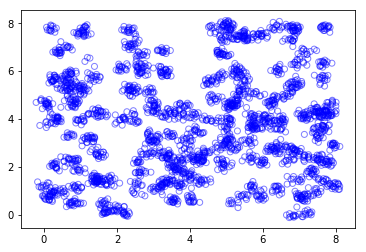

In [34]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

In [35]:
aa = ThomasPP(kappa=3, sigma=0.2, mu=7, Dx=8)

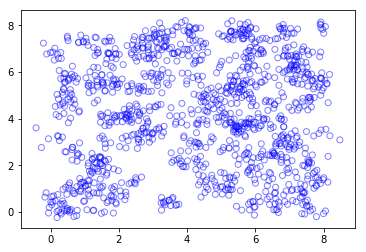

In [36]:
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )

Let's look at sigma, the rate/number of child points, keeping the parent point behavior (kappa) and child variation (mu) constant. 

In [50]:
a1 = ThomasPP(kappa=2, sigma=0.1, mu=30, Dx=10)
a2 = ThomasPP(kappa=2, sigma=0.1, mu=20, Dx=10)
a3 = ThomasPP(kappa=2, sigma=0.1, mu=10, Dx=10)

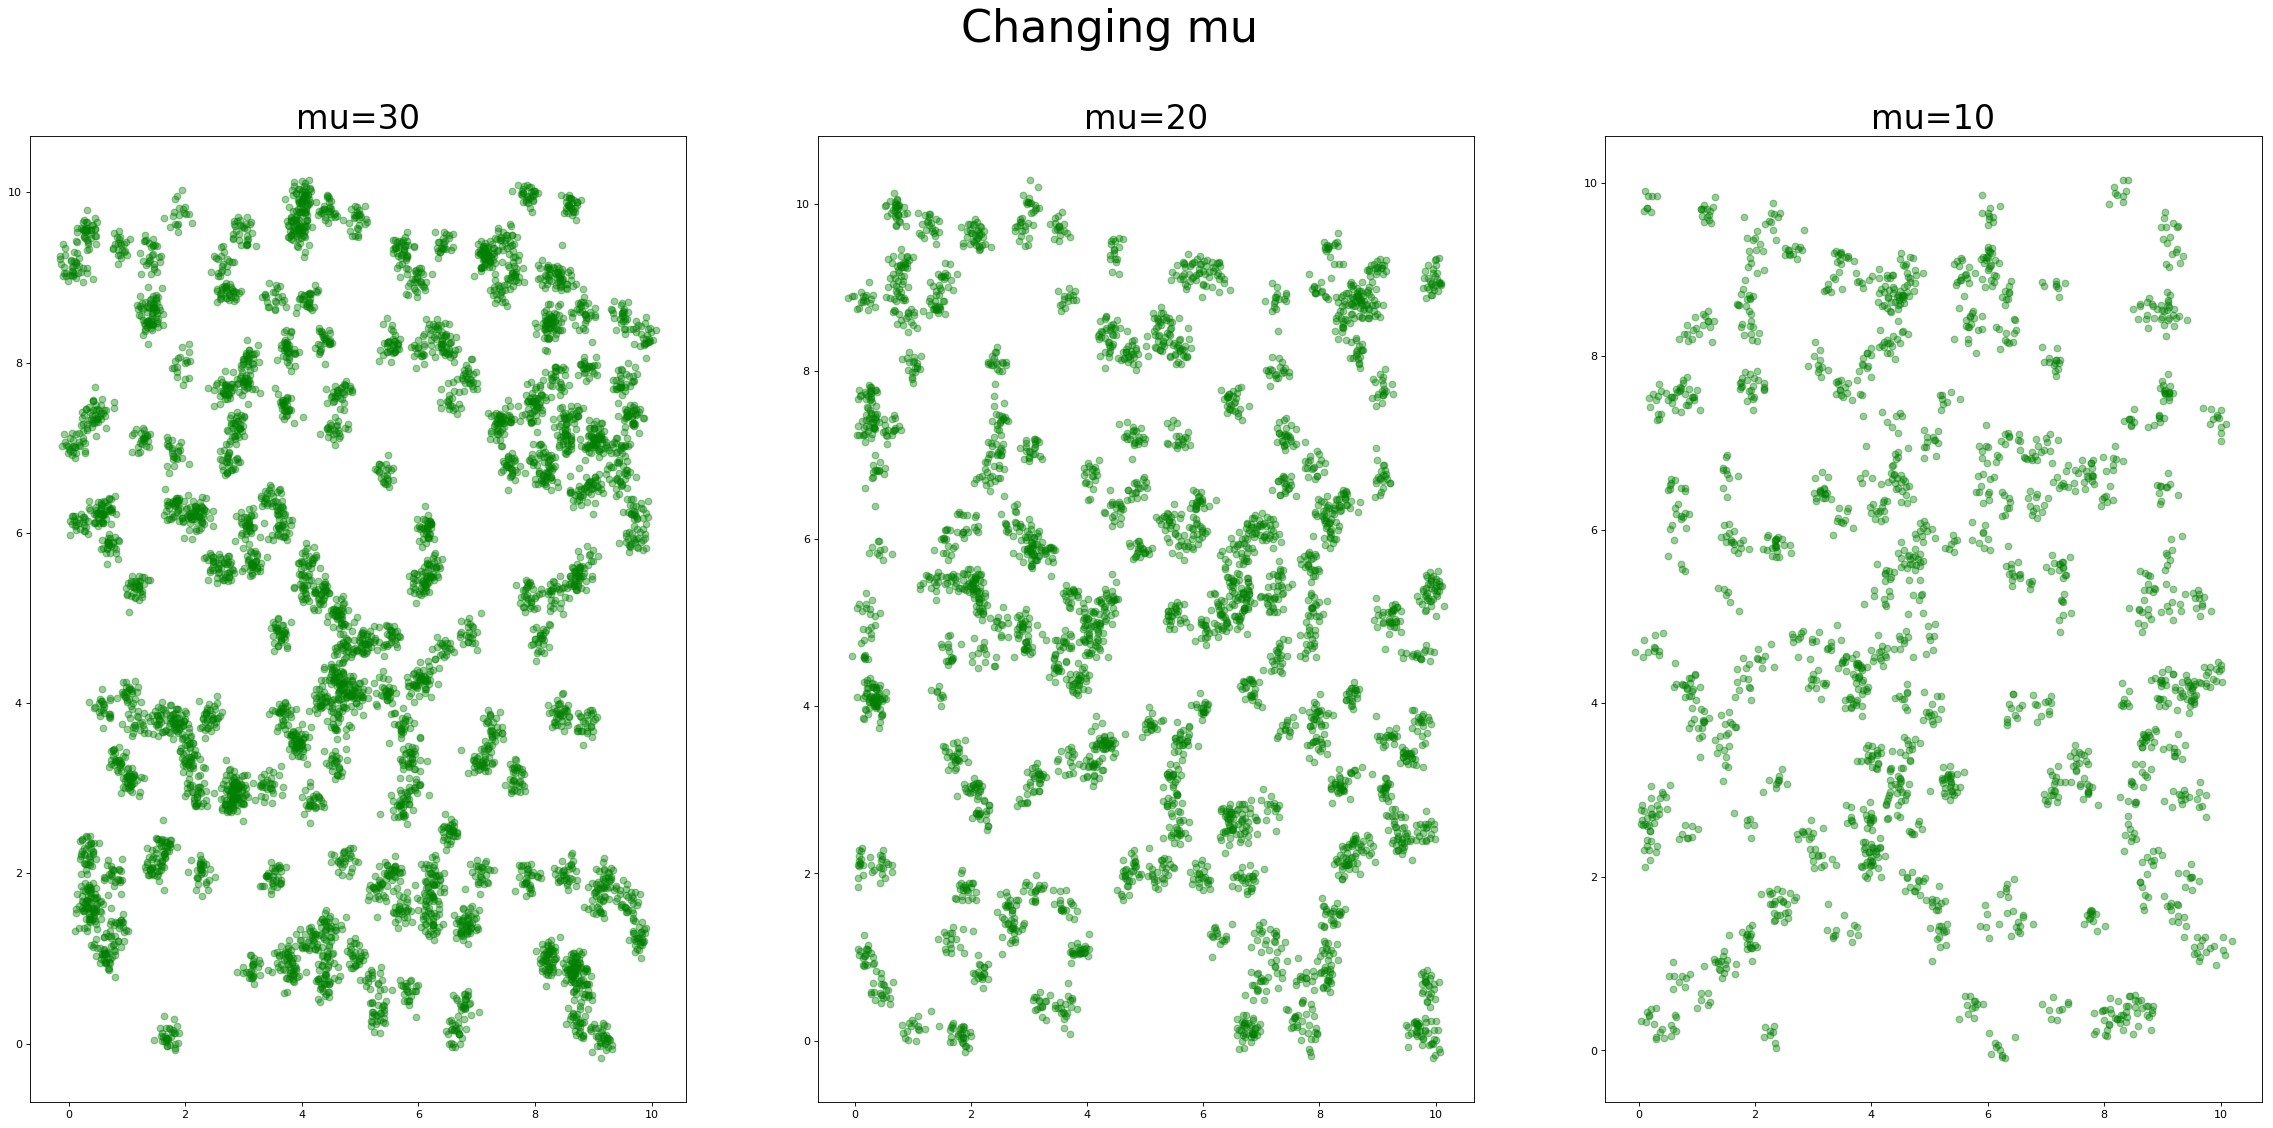

In [69]:
fig=plt.figure(figsize=(36, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle("Changing mu", fontsize=40)

plt.subplot(131)
plt.title("mu=30", fontsize=30)
plt.scatter(a1[0],a1[1], c='g', alpha = 0.4) 
plt.subplot(132)
plt.title("mu=20", fontsize=30)
plt.scatter(a2[0],a2[1], c='g', alpha = 0.4)
plt.subplot(133)
plt.title("mu=10", fontsize=30)
plt.scatter(a3[0],a3[1], c='g', alpha = 0.4)

In [70]:
[len(a1[0]),
len(a2[0]),
len(a3[0])]

[5995, 3837, 1999]

Makes sense, reducing mu by a third each time reduces the number of points by ~1/3. This results in more isolated clusters, just because there are fewer trees to bridge the gaps between. 

Now let's try varing sigma, the variance of the child points around their parents. 

In [79]:
b1 = ThomasPP(kappa=2, sigma=0.9, mu=20, Dx=10)
b2 = ThomasPP(kappa=2, sigma=0.5, mu=20, Dx=10)
b3 = ThomasPP(kappa=2, sigma=0.1, mu=20, Dx=10)

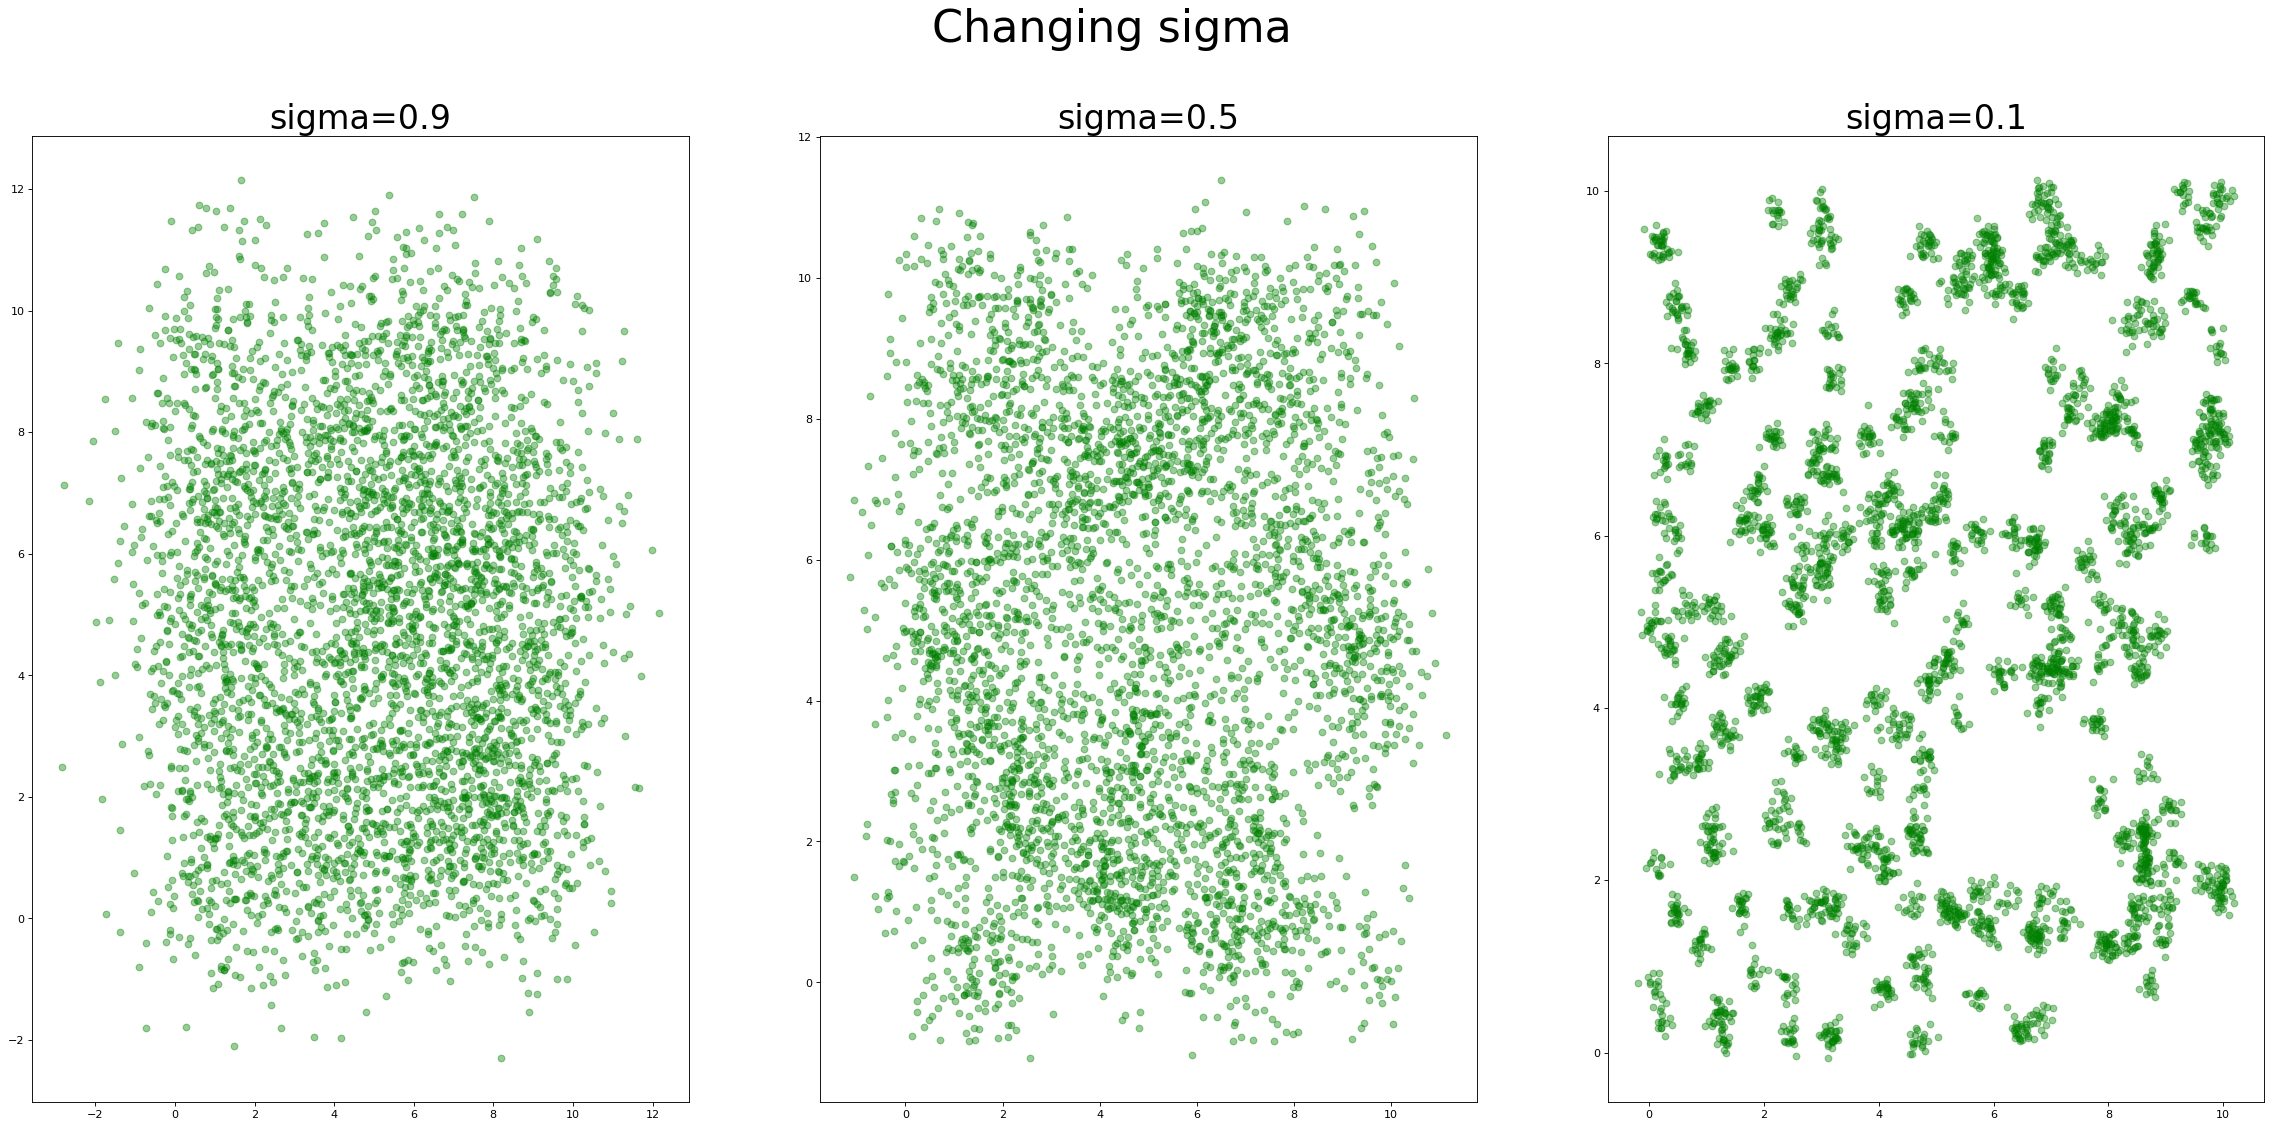

In [88]:
fig=plt.figure(figsize=(36, 16), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle("Changing sigma", fontsize=40)

plt.subplot(131)
plt.title("sigma=0.9", fontsize=30)
plt.scatter(b1[0],b1[1], c='g', alpha = 0.4) 
plt.subplot(132)
plt.title("sigma=0.5", fontsize=30)
plt.scatter(b2[0],b2[1], c='g', alpha = 0.4)
plt.subplot(133)
plt.title("sigma=0.1", fontsize=30)
plt.scatter(b3[0],b3[1], c='g', alpha = 0.4)

In [87]:
[len(b1[0]),
len(b2[0]),
len(b3[0])]

[4226, 4180, 4257]

Pretty obvious that lower sigma values create tighter clusters, with the same number of points.

We need our points to work with our mesa model grid. So points need to be rounded to the nearest whole numbers, and stay within our grid. The thomas process coded here gives off floating decimals and child points sometimes float off the edges of the grid. So an adapter function:

In [2]:
def makepos(rawpts, Dx=100):
    '''
    a function for getting the thomas points into 
    a useful format for mesa.
    '''
    ## round these floating decimal coords
    aa = [ int(round(i)) for i in rawpts[0] ]
    ## if too big, subtract:
    aatrim = [ i if i < Dx  else i-99 for i in aa ]
    bb = [ int(round(i)) for i in rawpts[1] ]
    ## if too big, subtract:
    bbtrim = [ i if i < Dx  else i-99 for i in bb ]
    ## make a set of unique tuples, for tree positions
    cc = list(set(list(zip(aatrim,bbtrim))))
    return(cc)

Try it out.

In [7]:
aa = ThomasPP(kappa=2, sigma=0.1, mu=20, Dx=10)
bb = makepos(aa)


In [9]:
bb

[(7, 3),
 (6, 9),
 (0, 7),
 (1, 6),
 (3, 7),
 (2, 5),
 (8, 5),
 (5, 8),
 (4, 0),
 (10, 8),
 (9, 0),
 (6, 7),
 (5, 5),
 (10, 7),
 (7, 6),
 (6, 10),
 (0, 4),
 (1, 1),
 (3, 2),
 (2, 6),
 (8, 2),
 (4, 5),
 (9, 3),
 (7, 5),
 (0, 1),
 (3, 1),
 (9, 9),
 (7, 8),
 (2, 1),
 (8, 9),
 (9, 4),
 (5, 1),
 (7, 2),
 (1, 5),
 (3, 6),
 (2, 2),
 (8, 6),
 (4, 1),
 (10, 9),
 (9, 7),
 (6, 4),
 (5, 4),
 (10, 4),
 (7, 1),
 (0, 5),
 (0, 8),
 (3, 5),
 (2, 7),
 (8, 3),
 (5, 10),
 (4, 6),
 (10, 10),
 (9, 2),
 (6, 1),
 (5, 7),
 (7, 4),
 (0, 2),
 (1, 3),
 (4, 8),
 (3, 0),
 (2, 8),
 (9, 8),
 (8, 0),
 (6, 2),
 (3, 10),
 (8, 10),
 (5, 0),
 (10, 0),
 (1, 4),
 (3, 9),
 (2, 3),
 (1, 9),
 (8, 7),
 (4, 2),
 (9, 6),
 (6, 5),
 (5, 3),
 (7, 0),
 (6, 8),
 (0, 6),
 (1, 7),
 (0, 9),
 (3, 4),
 (2, 4),
 (8, 4),
 (5, 9),
 (4, 7),
 (9, 1),
 (6, 6),
 (5, 6),
 (10, 6),
 (7, 7),
 (0, 3),
 (1, 2),
 (4, 9),
 (3, 3),
 (2, 9),
 (8, 1),
 (4, 4),
 (6, 3),
 (7, 10),
 (2, 10),
 (9, 10),
 (10, 1),
 (7, 9),
 (3, 8),
 (2, 0),
 (1, 8),
 (8, 8),
 (4

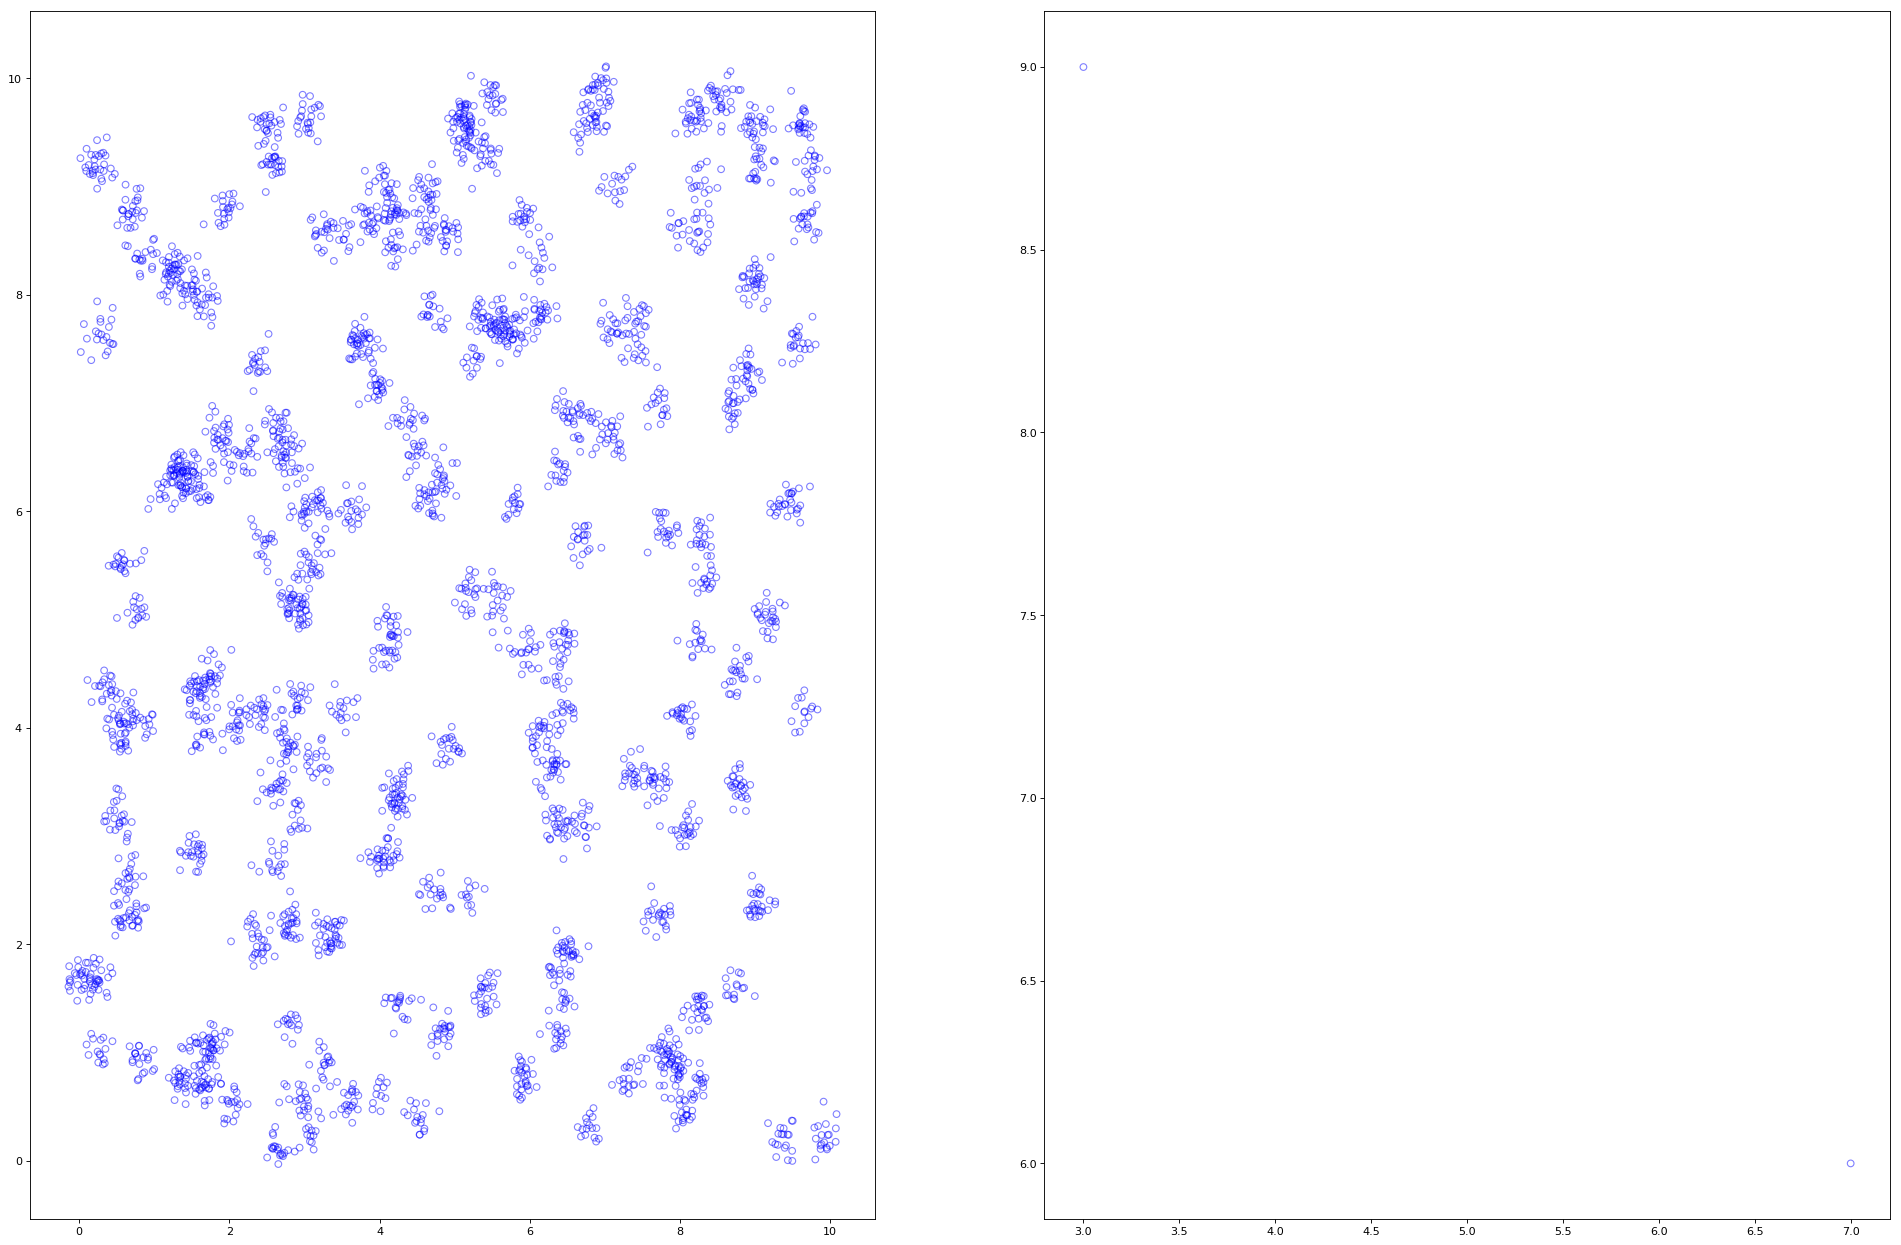

In [8]:
fig=plt.figure(figsize=(30, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter( aa[0], aa[1], edgecolor='b', facecolor='none', alpha=0.5 )
plt.subplot(122)
plt.scatter( bb[0], bb[1], edgecolor='b', facecolor='none', alpha=0.5 )